In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### The data
Our data contains some Latin characters. Column names are given in both French and English. An encoding is needed in this case, so we use ISO-8859-1.

Columns in French are dropped. Only needed columns are kept. Some renaming is also needed.

In [3]:
data = pd.read_csv(
    'data/cfia-acia-1211-childrens-food-project.csv', encoding = "ISO-8859-1")
data.head()


,Sample No.  No. déchantillon,Region - Région,Commodity,denrée,Function,Fonction,Origin,Origine,Product,Produit,Date Sampled  Date déchantillonage,Component,Composant,AMOUNT,Report Unit - Unité de rapport
0,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Diquat,diquat,0.0,µg/g
1,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Paraquat,paraquat,0.0,µg/g
2,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,AminomethylPhosphonic Acid,Acide (aminométhyl) phosphonique,0.0,µg/g
3,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Glyphosate,glyphosate,0.0,µg/g
4,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Aluminum,Aluminium,0.0,µg/g


In [5]:
# Let's select columns of interest 
cols = ['Region - Région', 'Function', 'Origin', 'Product', 'Component', 'AMOUNT']
children_food = data[cols].rename(columns={data.columns[1]: 'Region'})
children_food.head()


,Region,Function,Origin,Product,Component,AMOUNT
0,ONTARIO,Domestic,CANADA,Yogurt,Diquat,0.0
1,ONTARIO,Domestic,CANADA,Yogurt,Paraquat,0.0
2,ONTARIO,Domestic,CANADA,Yogurt,AminomethylPhosphonic Acid,0.0
3,ONTARIO,Domestic,CANADA,Yogurt,Glyphosate,0.0
4,ONTARIO,Domestic,CANADA,Yogurt,Aluminum,0.0


In [66]:
children_food.Function.unique()

array(['Domestic', 'Unknown', 'Import'], dtype=object)

#### Identification
Region: where the product was both Ontario or Quebec 
Function: 'Domestic', 'Unknown', 'Import' \
Origin: Country of origine of the product \
Poduct: Product name \
Component: Chemical components found in products \
AMOUNT: Measured value in $\mu$g/g 

In [7]:
# 1 if product has chemicals, 0 is none
children_food['Has_chemicals'] = np.where(children_food.AMOUNT == 0, 0, 1)
children_food.head()

,Region,Function,Origin,Product,Component,AMOUNT,Has_chemicals
0,ONTARIO,Domestic,CANADA,Yogurt,Diquat,0.0,0
1,ONTARIO,Domestic,CANADA,Yogurt,Paraquat,0.0,0
2,ONTARIO,Domestic,CANADA,Yogurt,AminomethylPhosphonic Acid,0.0,0
3,ONTARIO,Domestic,CANADA,Yogurt,Glyphosate,0.0,0
4,ONTARIO,Domestic,CANADA,Yogurt,Aluminum,0.0,0


#### The model

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [10]:
# Let's select and split our data
kids_food_X = children_food[['Origin', 'Product', 'Component', 'AMOUNT']]
kids_food_y = children_food['Has_chemicals']

X_train, X_val, y_train, y_val = train_test_split(
    kids_food_X, kids_food_y, random_state = 0)
#X_train.head()

Given that we are dealing with categorical data, we have to encode the training and test data.

In [11]:
encoder = preprocessing.LabelEncoder()
X_train_encoded = X_train.apply(encoder.fit_transform)
X_val_encoded = X_val.apply(encoder.fit_transform)
#X_train_encoded.head()
X_val_encoded.head()

,Origin,Product,Component,AMOUNT
112893,16,3,484,0
64395,1,2,212,0
103566,15,3,90,0
126923,15,4,217,0
63536,1,2,409,0


We can test and choose the best model

In [12]:
model1 = DecisionTreeRegressor()
model1.fit(X_train_encoded, y_train)
prediction = model1.predict(X_val_encoded)

print(mean_absolute_error(y_val, prediction))

0.0


In [15]:

model2 = RandomForestRegressor(random_state=1)
model2.fit(X_train_encoded, y_train)
prediction2 = model2.predict(X_val_encoded)

print(mean_absolute_error(y_val, prediction2))

3.0834853662923656e-06


In [16]:
output = pd.DataFrame({'Origin': X_val.Origin, 
                    'Has_chemicals': prediction2}).reset_index(drop=True)
output.head()


,Origin,Has_chemicals
0,UNKNOWN,0.0
1,CANADA,0.0
2,UNITED STATES,0.0
3,UNITED STATES,0.0
4,CANADA,0.0


#### Origin of products with highers number of chemicals 

<AxesSubplot:>

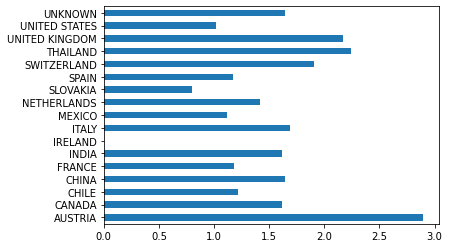

In [21]:
#output.groupby('Origin')['Has_chemicals'].sum().plot(kind='barh')

# Country with the highest percentage of products with chemicals
a = 100*output.groupby('Origin')['Has_chemicals'].sum()/(
    output.Origin.value_counts())
a.plot(kind='barh')

In [23]:
# The total percentage can also be measured ie for all measured products
#output.groupby('Origin').agg({"Has_chemicals" : "sum"}
                          #  ).apply(lambda x: 100*x/x.sum()
                              #     ).plot(kind='barh')